# Push Notificactions  
Predictive model: People interested in a product.  
Given a user and a product, predict if the wuold buy it if theywere buying at that moment.  
user with basket > 5 products
Linear model

## Getting ready

In [52]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import sklearn.linear_model 

import joblib

pd.options.display.max_columns = None

### Functions

In [53]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"{model_name}: AUC:{pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(F"precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr,tpr,label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()

In [54]:
def treatment_columns_categorical_encoding(
        dataframe: pd.DataFrame,
        column: str
    ):
    dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[column])],axis=1)
    dataframe = dataframe.drop(column,axis=1)
    return dataframe

### Load the data

In [55]:
folder_path = Path("D:/Users/maick/Desktop/Codigos/zrive-ds/data/box_builder_dataset/feature_frame.csv")
#folder_path = Path("C:/Users/AULA04/Desktop/Codes/zrive-ds/data/box_builder_dataset/feature_frame.csv")

In [ ]:
feature_frame = pd.read_csv(folder_path)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


## Preparation of the dataset

Filter for >5 products

In [57]:
size_of_order = feature_frame.groupby("order_id").outcome.sum()
size_of_order = size_of_order[size_of_order>=5]
feature_frame = feature_frame[feature_frame["order_id"].isin(size_of_order.index)]
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [58]:
(feature_frame["outcome"]).value_counts()

outcome
0.0    2132624
1.0      31329
Name: count, dtype: int64

pass to datetime

In [59]:
feature_frame["created_at"] = pd.to_datetime(feature_frame["created_at"])
feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date

C:\Users\maick\AppData\Local\Temp\ipykernel_15444\3793107625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_frame["created_at"] = pd.to_datetime(feature_frame["created_at"])
C:\Users\maick\AppData\Local\Temp\ipykernel_15444\3793107625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date


In [ ]:
orders_diary = feature_frame.groupby("order_date").order_id.nunique()
porcentaje_orders_dairy = orders_diary.cumsum() / orders_diary.sum()
train_val_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.7].idxmax()
val_test_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.9].idxmax()
print(f"The 70% of orders were before the {train_val_cutoff}")
print(f"The 90% of orders were before the {val_test_cutoff}")
orders_diary.plot(kind="line")
plt.axvline(x=pd.to_datetime(train_val_cutoff), color='red', linestyle='--', label="70%")
plt.axvline(x=pd.to_datetime(val_test_cutoff), color='green', linestyle='-', label="90%")
plt.legend()

The 70% of orders were before the 2021-02-04
The 90% of orders were before the 2021-02-22


In [62]:
feature_frame = (feature_frame.sort_values("order_date",ascending=True).reset_index()).drop("index",axis = 1)
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33667182035076,shavinggrooming,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,33667182035076,shavinggrooming,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,33667182035076,shavinggrooming,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,33667209199748,dishwasherdetergent,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,ecover,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,34276570824836,condimentsdressings,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,34276570824836,condimentsdressings,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,34276570824836,condimentsdressings,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,33826456961156,babyfood6months,3643229274244,3536923295876,2021-03-03 12:36:28,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,annabelkarmel,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


### Columns no numeric

#### Product type

In [ ]:
# Delete:
feature_frame = feature_frame.drop("variant_id",axis=1)
feature_frame = feature_frame.drop("user_id",axis=1)
feature_frame = feature_frame.drop("created_at",axis=1)
feature_frame = feature_frame.drop("order_id",axis=1)

### Separate the dataframe

In [66]:
column_numerics = []
for columns in feature_frame.dtypes:
    if columns == "int64" or columns == "float64":
        column_numerics.append(True)
    else:
        column_numerics.append(False)

feature_frame_numeric = feature_frame.loc[:, column_numerics]
feature_frame_numeric

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


## Divide the dataset

In [67]:
y = feature_frame_numeric["outcome"]
x = feature_frame_numeric.drop(columns=["outcome"])

I try two ways to divide the dataset to view the diferent results
1. Randomly, 10% data for test, aprox 20% for valid and aprox 80% for train 

### Random

In [95]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

print(f"Train: {len(x_train)} ")
print(f"Valid: {len(x_valid)} ")
print(f"Test: {len(x_test)} ") 

Train: 1558045 
Valid: 389512 
Test: 216396 


### Temporarily

2. Temporarily, where the 70% goes until 2021-02-04 division for test and valid goes until 2021-02-22

In [89]:
x_train = x.iloc[:int(len(x)*0.7)]
x_test = x.iloc[int(len(x)*0.7):int(len(x)*0.9)]
x_valid = x.iloc[int(len(x)*0.9):]

y_train = y.iloc[:int(len(y)*0.7)]
y_test = y.iloc[int(len(y)*0.7):int(len(y)*0.9)]
y_valid = y.iloc[int(len(y)*0.9):]

print(f"Train: {len(x_train)} and {len(y_train)} ")
print(f"Valid: {len(x_valid)} and {len(y_valid)}")
print(f"Test: {len(x_test)} and {len(y_test)}") 

Train: 1514767 and 1514767 
Valid: 216396 and 216396
Test: 432790 and 432790


In [ ]:
#checking
(x_train.shape[0]+x_test.shape[0]+x_valid.shape[0] == len(x)
and
y_train.shape[0]+y_test.shape[0]+y_valid.shape[0] == len(y))

True

## Normalization

In [91]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x.columns)
x_train

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0.105263,0.0,0.0,0.0,0.0,0.099174,0.081848,0.058153,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.345238,0.298334,0.202703,0.646154,0.609283
1,0.315789,0.0,0.0,0.0,0.0,0.355372,0.165133,0.031267,0.25,0.666667,0.0,0.333333,0.75,0.222973,0.523810,0.444821,0.168919,0.769231,0.701343
2,0.315789,0.0,0.0,0.0,0.0,0.388430,0.161524,0.004710,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.273810,0.102315,0.202703,0.600000,0.596288
3,0.210526,0.0,0.0,0.0,0.0,0.052342,0.179412,0.018127,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.630952,0.554246,0.202703,0.923077,0.843486
4,0.105263,0.0,0.0,0.0,0.0,0.231405,0.123909,0.000000,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.095238,0.458813,0.202703,0.892308,0.766459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558040,0.105263,0.0,0.0,0.0,0.0,0.063361,0.057287,0.047485,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.464286,0.466262,0.202703,0.800000,0.765928
1558041,0.000000,0.0,0.0,0.0,0.0,0.011019,0.399287,0.027062,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.416667,0.510005,0.202703,0.800000,0.765928
1558042,0.052632,0.0,0.0,0.0,0.0,0.088154,0.060329,0.005403,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.535714,0.570017,0.202703,0.800000,0.765928
1558043,0.000000,0.0,0.0,0.0,0.0,0.242424,0.198656,0.000000,0.25,0.000000,0.0,0.000000,0.25,0.222973,0.369048,0.428995,0.202703,0.600000,0.596288


## Baseline

In [ ]:
binary_predictions = (feature_frame["global_popularity"] >= 0.5).astype(int)

print("Validación:\n", classification_report(feature_frame["outcome"], binary_predictions))

c:\Users\maick\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-yh3a_Qli-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maick\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-yh3a_Qli-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validación:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   2132624
         1.0       0.00      0.00      0.00     31329

    accuracy                           0.99   2163953
   macro avg       0.49      0.50      0.50   2163953
weighted avg       0.97      0.99      0.98   2163953



c:\Users\maick\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-yh3a_Qli-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


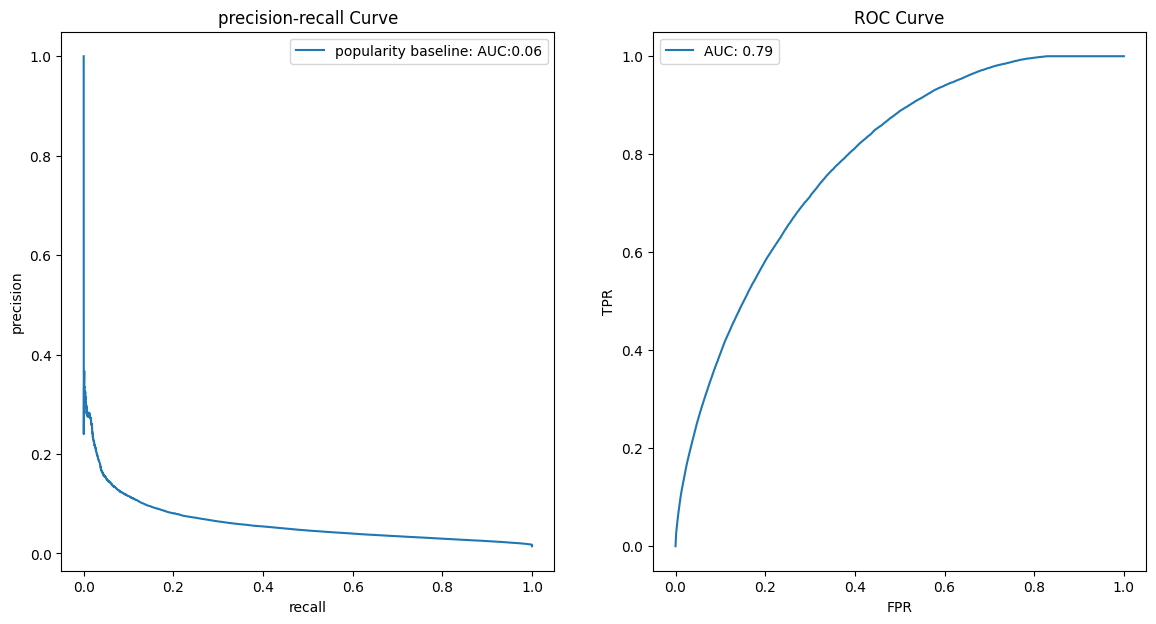

In [22]:
plot_metrics("popularity baseline", y_pred=feature_frame["global_popularity"], y_test=feature_frame["outcome"])

### LogisticRegression

In [92]:
LogReg_model = LogisticRegression(
    class_weight="balanced", 
    random_state=42,
    )

LogReg_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [94]:
y_test_pred = LogReg_model.predict(x_test)
print("Validación:\n", classification_report(y_test, y_test_pred))

Validación:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    213263
         1.0       0.02      0.01      0.01      3133

    accuracy                           0.98    216396
   macro avg       0.50      0.50      0.50    216396
weighted avg       0.97      0.98      0.98    216396



In [73]:
cross_val_score(LogReg_model, x_train, y_train, cv=5, scoring='recall').mean()

0.6269337287137255

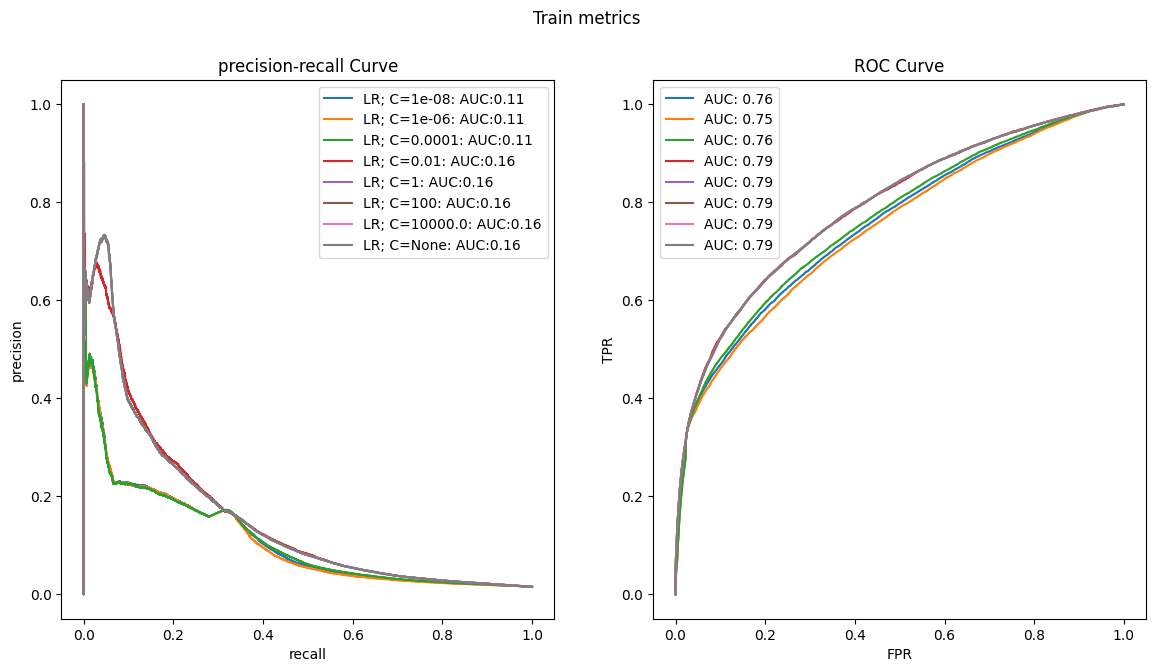

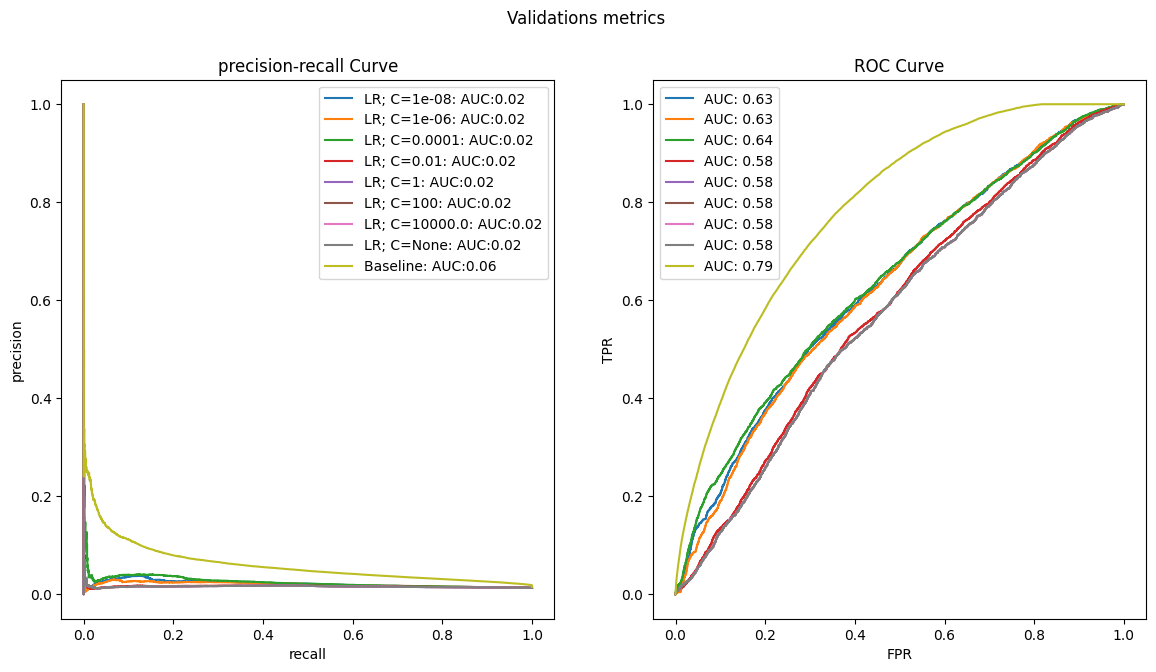

In [51]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validations metrics")

cs = [1e-8,1e-6,1e-4,1e-2,1,100,1e4,None]
for c in cs:
    LogReg_model = LogisticRegression(penalty="l2",C=c if c else 1.0)
    LogReg_model.fit(x_train,y_train)
    train_proba = LogReg_model.predict_proba(x_train)[:,1]
    plot_metrics(
        f"LR; C={c}",y_pred=train_proba,y_test=y_train,figure=(fig1,ax1)
    )
    
    val_proba = LogReg_model.predict_proba(x_valid)[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_valid, figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred=x_train["global_popularity"],
    y_test=y_train,
    figure=(fig2,ax2),
)

Ridge Regression

In [ ]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validations metrics")

cs = [1e-8,1e-6,1e-4,1e-2,1,100,1e4,None]
for c in cs:
    LogReg_model = LogisticRegression(penalty="l1",C=c if c else 1.0, solver="saga")
    LogReg_model.fit(x_train,y_train)
    train_proba = LogReg_model.predict_proba(x_train)[:,1]
    plot_metrics(
        f"LR; C={c}",y_pred=train_proba,y_test=y_train,figure=(fig1,ax1)
    )
    
    val_proba = LogReg_model.predict_proba(x_valid)[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_valid, figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred=x_train["global_popularity"],
    y_test=y_train,
    figure=(fig2,ax2),
)

### RandomForestClassifier

### Vectores de Soporte Lineales (Linear SVM)

### Test the model

### Save the model

In [ ]:
joblib.dump(model, "models/model_MVP_RandomForestClassifier_01.pkl")